In [16]:
# Author: Norgey Bilinsky, TSU

# Оптимизация гиперпараметров
## Базовое решение на xgboost

In [17]:
import matplotlib.pylab as plt # Для визуализации
# Author: Norgey Bilinsky, TSU
import numpy as np # Для работы с массивами
import pandas as pd # Для работы с таблицами

In [18]:
from rdkit import Chem
from rdkit.Chem import AllChem # Нужен для построения вектора фингерпринтов

from sklearn.model_selection import train_test_split # Нужно для создание тренировочной и тестовой выборки
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Метрики для регрессий
from sklearn.model_selection import RandomizedSearchCV # Для подбора гиперпараметров

from xgboost import XGBRegressor 


In [19]:
# Загрузка данных
df_full = pd.read_csv("summary.csv", index_col=0, nrows=10000)
df_full = df_full[df_full['CONFORMER id'] == 0]

In [20]:
# Применяем функцию ко всем значениям в колонке 
# и пишем новую колонку
df_full["mol"] = df_full["SMILES"].apply(Chem.MolFromSmiles)

In [21]:
# Расчёт Моргановских фингерпринтов
df_full["fingerprint"] = df_full["mol"].apply(lambda m: np.array(AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=512)))

In [22]:
df_full["fingerprint"]

0      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
24     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...
25     [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
26     [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
                             ...                        
981    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
988    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
991    [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...
994    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
996    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: fingerprint, Length: 304, dtype: object

In [23]:
df_full['DFT FORMATION ENERGY']

0     -6.395356
6     -7.744498
24    -7.038037
25    -5.436545
26    -5.492884
         ...   
981   -6.878778
988   -6.850900
991   -5.271046
994   -7.164192
996   -5.521666
Name: DFT FORMATION ENERGY, Length: 304, dtype: float64

In [24]:
X_full = np.vstack(df_full["fingerprint"].values)
Y_full = df_full['DFT FORMATION ENERGY'].values

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_full, Y_full, test_size=0.2, random_state=42
)

In [26]:
# Инициализация модели
xgb = XGBRegressor(
    random_state=42,
    n_jobs=-1
)

# Обучение
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [27]:
y_pred = xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 0.7503
R²: 0.4753


In [28]:
# Ручной расчёт MAE, основной метрики для этой задачи
np.mean(np.abs((y_test - y_pred)))

0.6327446446766343

## Оптимизация гиперпараметров через Grid search

Начинаем поиск лучших гиперпараметров...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Лучшие параметры: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 1.0, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Лучший MAE (CV): 0.575007

Сравнение результатов:
MAE (оригинальная модель): 0.632745
MAE (оптимизированная): 0.613743
MSE (оптимизированная): 0.573540
R² (оптимизированная): 0.465421
Улучшение MAE: 3.00%


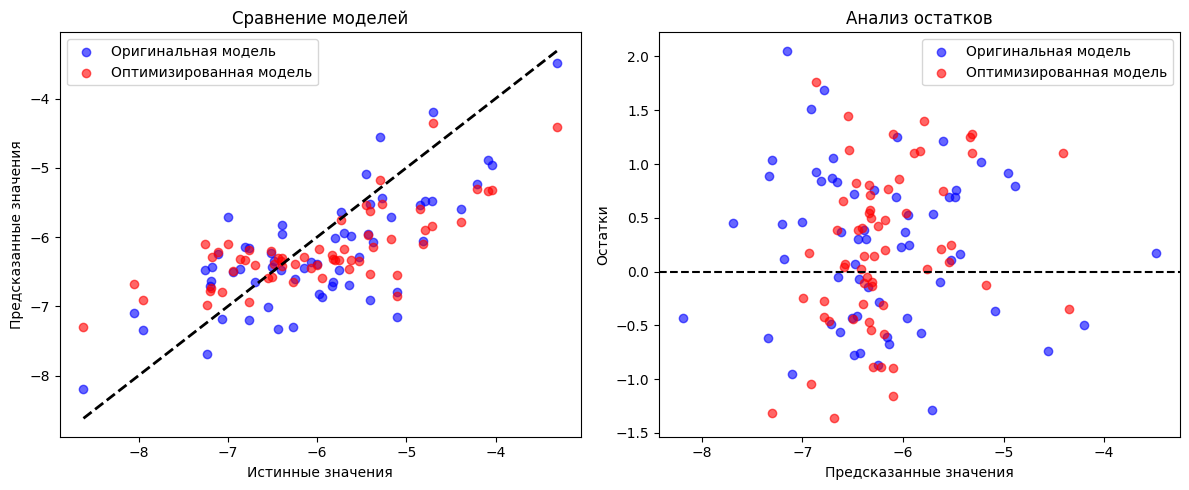

In [29]:
# Определяем пространство гиперпараметров для XGBoost
param_distributions = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}

# Создаем RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=50,  # Количество случайных комбинаций
    cv=3,       # 3-fold cross-validation
    scoring='neg_mean_absolute_error',  # Метрика для оптимизации
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Запускаем поиск
print("Начинаем поиск лучших гиперпараметров...")
random_search.fit(X_train, y_train)

# Получаем лучшие параметры
best_params = random_search.best_params_
best_score = -random_search.best_score_  # Отрицательное, так как scoring='neg_mean_absolute_error'

print(f"\nЛучшие параметры: {best_params}")
print(f"Лучший MAE (CV): {best_score:.6f}")

# Обучаем модель с лучшими параметрами
best_xgb = random_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

# Сравниваем результаты
mae_original = np.mean(np.abs(y_test - y_pred))
mae_optimized = mean_absolute_error(y_test, y_pred_best)
mse_optimized = mean_squared_error(y_test, y_pred_best)
r2_optimized = r2_score(y_test, y_pred_best)

print(f"\nСравнение результатов:")
print(f"MAE (оригинальная модель): {mae_original:.6f}")
print(f"MAE (оптимизированная): {mae_optimized:.6f}")
print(f"MSE (оптимизированная): {mse_optimized:.6f}")
print(f"R² (оптимизированная): {r2_optimized:.6f}")
print(f"Улучшение MAE: {((mae_original - mae_optimized) / mae_original * 100):.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6, label='Оригинальная модель', color='blue')
plt.scatter(y_test, y_pred_best, alpha=0.6, label='Оптимизированная модель', color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение моделей')
plt.legend()

plt.subplot(1, 2, 2)
residuals_orig = y_test - y_pred
residuals_opt = y_test - y_pred_best
plt.scatter(y_pred, residuals_orig, alpha=0.6, label='Оригинальная модель', color='blue')
plt.scatter(y_pred_best, residuals_opt, alpha=0.6, label='Оптимизированная модель', color='red')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Анализ остатков')
plt.legend()

plt.tight_layout()
plt.show()


## Оценка важности признаков

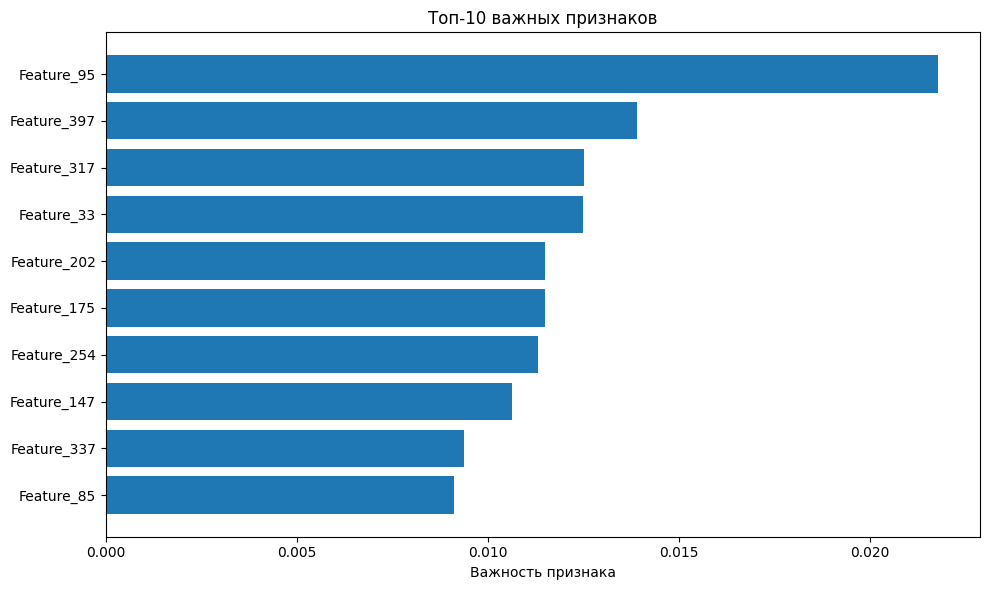

In [30]:
# Показываем важность признаков (XGB так умеет, некоторые библиотеки нет)
# Вообще определение значимости признаков заслуживает отдельной лекции
feature_importance = best_xgb.feature_importances_
feature_names = [f'Feature_{i}' for i in range(len(feature_importance))]

# Топ-10 важных признаков
top_features = np.argsort(feature_importance)[-10:]
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), feature_importance[top_features])
plt.yticks(range(len(top_features)), [f'Feature_{i}' for i in top_features])
plt.xlabel('Важность признака')
plt.title('Топ-10 важных признаков')
plt.tight_layout()
plt.show()
